# Reporte de práctica 7: Regresión múltiple con statsmodels

En esta práctica es parecida a la anterior, solo que ahora los modelos lineales tendrán más de un factor.

## Objetivo 
- Incluir por lo menos un modelo de regresión múltiple 
- Intentar usar sus resultados como un clasificador de alguna variable de interés para el proyecto.

### Cargar datos de csv

Primero importamos el archivo que está en GitHub que tiene información limpia de prácticas pasadas.

In [1]:
import statsmodels.api as sm
from numpy import isnan
import pandas as pd
cine = pd.read_excel('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/2018.xlsx', index_col=None, header=0, sheet_name=0)
cine = cine[['Categoria','Edad','Pais', 'Titulo','Genero', 'Duracion', 'Marca','Referencia','Dias','Marcas','Personas','Sinopsis']]

cine = cine.dropna()

print(len(cine))

266


Se quiere probar si la cantidad de personas que participaron en el filme esta relacionada con la Duruacion de este, la categoría a la que pertenece y a los Dias de grabacion. Se categoriza la categoría del filme utilizando la librería pandas.Categorical().

In [2]:
cat = pd.Categorical(cine.Categoria)
cine['cat'] = cat.codes

## Mínimos cuadrados ordinarios

Los mínimos cuadrados ordinarios sirven para encontrar los parámetros poblacionales en un modelo de regresión lineal. Este método minimiza la suma de las distancias verticales entre las respuestas observadas en la muestra y las respuestas del modelo. El parámetro resultante puede expresarse a través de una fórmula sencilla, especialmente en el caso de un único factor. 

Para hacer la regresión se confirma que la cantidad de datos que se tienen sea mayor a ocho.

In [3]:
n = len(cine)
if n >= 8: 
    y = cine["Personas"]
    x = cine[["Duracion", "cat", "Dias"]]
    m = sm.OLS(y, x).fit() 
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:               Personas   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     88.31
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.48e-39
Time:                        21:26:28   Log-Likelihood:                -952.98
No. Observations:                 266   AIC:                             1912.
Df Residuals:                     263   BIC:                             1923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Duracion       0.0012      0.000      3.733      0.0

Se verifica si los campos se encuentran correlacionados entre ellos. Por que afectaría si en el modelo trabajamos con columnas que estén fuertemente correlacionados.

              Edad  Duracion      Dias    Marcas  Personas       cat
Edad      1.000000 -0.067706 -0.067153 -0.069770 -0.012014 -0.022563
Duracion -0.067706  1.000000  0.028244  0.571155  0.204051  0.044962
Dias     -0.067153  0.028244  1.000000  0.012944  0.179026  0.102243
Marcas   -0.069770  0.571155  0.012944  1.000000  0.102514 -0.046332
Personas -0.012014  0.204051  0.179026  0.102514  1.000000  0.224517
cat      -0.022563  0.044962  0.102243 -0.046332  0.224517  1.000000


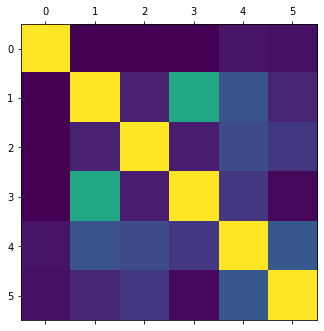

In [4]:
import matplotlib.pyplot as plt
f = plt.figure(figsize = (12, 12))  
print(cine.corr())
sf = f.add_subplot(211)
tmp = sf.matshow(cine.corr())

Se puede ver que ningún parámetro se encuentra fuertemente correlacionado. Esto indica que todos los parámetros son independientes.

Se realiza una grafica de dispersión para determinar que variables nos conviene estudiar.

266


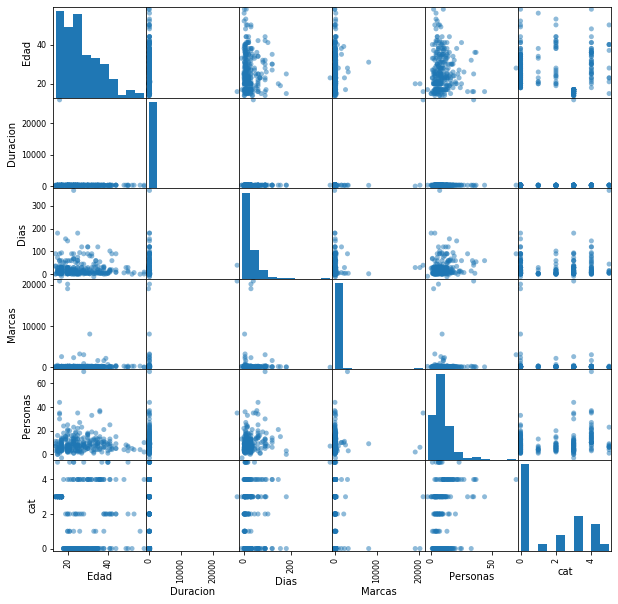

In [5]:
print(len(cine))
tmp = pd.plotting.scatter_matrix(cine, figsize = (10, 10), s =100) 

En este caso, los datos se encuentran dispersos. Se puede observar que no están correlacionados. En los histogramas de la diagonal principal se observa que la distribución de los datos no es normalmente distribuida.

## Usar los resultados como clasificador

A pesar de que no se obtuvieron los resultados deseados, se intenta predecir el tamaño de la sinopsis en función del género, categoría y país del filme y la marca del smartphone con el cual se grabó el filme. Este tamaño no deberá ser mayor a 140 caracteres, como limite de Twitter.

In [6]:
y = cine["Personas"]
x = cine[["Duracion", "cat", "Dias"]]
m = sm.OLS(y, x).fit() 
comp = pd.DataFrame(cine, columns = ["Personas"])
comp['pron'] = m.predict(x) 
comp['error'] = comp.Personas - comp.pron
comp['absE'] = pd.DataFrame.abs(comp['error'])
orden = comp.sort_values(by = ['absE'])
mejores = orden.head(10)
mejores.insert(0, 'tipo', 'mejores')
peores = orden.tail(10)
peores.insert(0, 'tipo', 'peores')
pd.concat([mejores, peores])
n = len(comp)
for e in [1, 5, 10]:
    k = sum(comp.absE < e)
    print(k, "de", n , "= {:.2f}% estuvieron dentro de".format(100 * k / n), e, "% de error del valor real")

26 de 266 = 9.77% estuvieron dentro de 1 % de error del valor real
136 de 266 = 51.13% estuvieron dentro de 5 % de error del valor real
230 de 266 = 86.47% estuvieron dentro de 10 % de error del valor real


Se vera qué tanto cambia si no usamos el estimado del la marca del smartphone. Para esto se considerarán las siguientes variables.


    fp = falsos positivos: según el modelo pasan, pero en realidad no pasan.
    fn = falsos negativos: según el modelo reprueban, pero en realidad pasan.
    tp = verdaderos positivos: pasan en la realidad y también según el modelo.
    tn = verdaderos negativos: reprueban en la realidad y también según el modelo.

Teniendo tt = tp + tn + fp + fn podemos calcular

    La sensibilidad: tp / (tp + fn) que mide qué tan bien se modela los que aprueban.
    La especificidad: tn / (tn + fp) que mide qué tan bien se modela los que reprueban.
    La precisión: (tp + tn) / tt que mide el desempeño total de La asignación correcta de la clasificación que concluimos de este modelo lineal de regresión múltiple.

In [7]:
y = cine["Personas"]
x = cine[["Duracion", "cat", "Dias"]]
m = sm.OLS(y, x).fit() 
comp = pd.DataFrame(cine, columns = ["Personas"])
comp['pron'] = m.predict(x) 
comp['error'] = comp.Personas - comp.pron
comp['absE'] = pd.DataFrame.abs(comp['error'])
orden = comp.sort_values(by = ['absE'])
mejores = orden.head(10)
mejores.insert(0, 'tipo', 'mejores')
peores = orden.tail(10)
peores.insert(0, 'tipo', 'peores')
pd.concat([mejores, peores])
n = len(comp)
for e in [1, 5, 10]:
    k = sum(comp.absE < e)
    print(k, "de", n , "= {:.2f}% estuvieron dentro de".format(100 * k / n), e, \
          "% de error del valor real")
fp = sum((comp.Personas < 9) & (comp.pron >= 9))
fn = sum((comp.Personas >= 9) & (comp.pron < 9))
tp = sum((comp.Personas >= 9) & (comp.pron >= 9))
tn = sum((comp.Personas < 9) & (comp.pron < 9))
print('Clasificación')
print(fp, fn, tp, tn)
tt = tp + tn + fp + fn
print('sensibilidad', tp / (tp + fn))
print('especificidad', tn / (tn + fp))
print('precisión', (tp + tn) / tt)

26 de 266 = 9.77% estuvieron dentro de 1 % de error del valor real
136 de 266 = 51.13% estuvieron dentro de 5 % de error del valor real
230 de 266 = 86.47% estuvieron dentro de 10 % de error del valor real
Clasificación
33 69 48 116
sensibilidad 0.41025641025641024
especificidad 0.7785234899328859
precisión 0.6165413533834586


A pesar de que esta versión tiene mejores resultados, parece que este modelo es incapaz de predecir o clasificar, falsos negativos y verdaderos negativos ya que la función con la que predice no es muy buena.

## Conclusión

Se trabajó con parámetros que eran cadenas de caracteres y se utilizó la función Categorical para convertirlos a números y poder hacer la regresión tomando en cuenta estos parámetros no numéricos. Al hacer la regresión de mínimos cuadrados ordinarios se obtuvo un valor de R2 de 0.502. Se intentó clasificar por el conjunto de personas. Donde se filtraban los elementos que fueran menores o iguales a 9 integrantes, para poder clasificarlos. Con lo cual se pudo acercar al 86.47% de clasificación de los filmes. Posteriormente se realizó una prueba considerando falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos. 

--05 de junio 2019-- Luis Angel Gutiérrez Rodríguez 1484412